# "Charting Careers: The Data Map of Acting Success and Collaborations"

**group**: ImportNumpyasPd


Import library :

In [25]:
import pickle
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import community
import collections
from scipy.stats import chi2_contingency
import matplotlib.lines as mlines
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import plotly.subplots as sp
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.cm as cm
from collections import Counter

from src.utils.data_utils import *
from src.utils.general_utils import *
from src.utils.Director_Actor import *
from src.utils.Plot_Director_Actor import *
from src.utils.mapping import *
from src.utils.langue import *
from src.utils.career import *
from src.utils.stat_test import *

Import data set :

In [26]:
movie_path = 'data/Movie.pkl'
actors_path = 'data/Actor.pkl'
Movie = pd.read_pickle(movie_path)
Actor = pd.read_pickle(actors_path)

## 1. Career profiles

The aim of this section is to analyze the evolution of an actor's career. To do this, we will examine the number of films played by each actor in each year of his career in order to establish career profiles. Next, we'll group together actors with similar career profiles and describe the patterns of each group using actor characteristics.

We want to answer the research question: **what are the characteristics that unify players of the same career profile?**

In summary, the workflow is as follows:
- **select a part of dataset** that contains clean information about the characteristics that we want to analyze
- **build the actor's career profile** use the age of the actors at each movie to build the profiles based on the number of films per year of thier career.
- finding **suitable cluster** using K-means that represent well the data.
- **visualization** of few characteristics in each cluster to compare and perform some statistical tests.

In [27]:
# create dataset for career analysis that contains information about number of movie, age, gender, height.
Actor_career = create_actor_career_dataset(Actor)
#print infos
print(f" We have {Actor_career.shape[0]} samples for the analysis, initally we had {Actor.shape[0]} samples. ({Actor_career.shape[0]/Actor.shape[0]*100:.2f} %)")

 We have 50843 samples for the analysis, initally we had 135760 samples. (37.45 %)


### 1.1 Career clustering

Next section performs a **K-means** after identifying a suitable number of clusters with the elbow method.

In [28]:
# drop unnecessary columns and scale value in prevision of making K-means
Career_dataset_std = prepare_career_dataset_KMeans(Actor_career)

In [29]:
# plot elbow to select suitable number of cluster
plot_elbow_method(Career_dataset_std,range(1,10),random_state=50)

100%|██████████| 9/9 [00:04<00:00,  2.09it/s]


We take only 3 clusters as we still want to be able to analyse each cluster. 

In [30]:
#set number of cluster based on elbow plot :
n_cluster = 3
#do clustering relatively to the  n cluster 
labels = kmeans_clustering(Career_dataset_std, n_cluster, random_state=50)
# add a column label
Actor_career['Labels'] = labels

Size of each cluster are :

In [31]:
dict_cluster = get_dict_cluster(n_cluster, Actor_career, label_column='Labels')
print("Number of samples per cluster :")
print(f"cluster 0 :{dict_cluster[0].shape[0]} ({100*dict_cluster[0].shape[0]/Actor_career.shape[0]:.2f} %) , cluster 1 :{dict_cluster[1].shape[0]} ({100*dict_cluster[1].shape[0]/Actor_career.shape[0]:.2f} %) , cluster 2 :{dict_cluster[2].shape[0]} ({100*dict_cluster[2].shape[0]/Actor_career.shape[0]:.2f} %)")

Number of samples per cluster :
cluster 0 :47817 (94.05 %) , cluster 1 :2813 (5.53 %) , cluster 2 :213 (0.42 %)


### 1.2  Visualisation of the characteristics of each cluster

Plot the **centroids** of the career profiles for each cluster:

In [32]:
plot_career_data(Actor_career,labels,n_clusters=n_cluster)

The 3 labels can be summarized as :
- Cluser 0 - **One-Time Performers** : Very short career. Often a one-time actor with no real career. They represent the most part of the dataset. (94.05%)
- Cluser 1 - **The Steady Professionals** : These are the professional actors. They have a typical, lasting career. 
- Cluser 2 - **The Superstars**: This elite group of just over 200 actors is the most prolific, with the most long-lasting career. 

Let's have a look at some typical careers of well-known actors!

In [33]:
#plot career of our brother Yao Ming
plot_career_data(Actor_career, labels,"Yao Ming")

In [34]:
#most prolific actor 
plot_career_data(Actor_career,labels,"Mel Blanc")

In [35]:
#Well known and very prolific
plot_career_data(Actor_career,labels,"Samuel L. Jackson")

In [36]:
#Well known and very prolific
plot_career_data(Actor_career,labels,"Uma Thurman")

We plot the distribution of the number of films for each actor to check how the **clustering algorithm** split our data.

In [37]:
plot_cluster_histogram(Actor_career, 'Total_number_of_films', n_clusters=3, bin_width=3,logscale = True,max_value=300, min_value=-5, alpha = 0.5)

Cluster 0 appears in way fewer movies.
The most productive actors are in either cluster 1 or 2.

Now we inspect some characteristics of the actors in each cluster.

In [38]:
plot_cluster_histogram(Actor_career, 'actor_height', n_clusters=n_cluster, bin_width=0.03, max_value=2.5, min_value=0.5, logscale = True)

Visually, it seems that there are no statistical differences in terms of height distribution between clusters. Let's do a **t-test** to be sure:

**null hypothesis H0** : the normal distribution have the same average

In [39]:
#Do a t-test between the "norm" (cluster 0) and other clusters to see if there are differences
# Test null hypothesis H0 : the normal distribution have the same average
ttest(dict_cluster[0],dict_cluster[1],'actor_height')
ttest(dict_cluster[0],dict_cluster[2],'actor_height')

The null hypothesis can't be rejected, there is no significance differences. (p_value : 0.692502127833366)
The null hypothesis can't be rejected, there is no significance differences. (p_value : 0.9215740190524658)


(np.float64(0.09845370437288525), np.float64(0.9215740190524658))

This is confirmed! The only visual differences are in the extremities. It seems that despite some exceptions, actors outside of the norms always end up in cluster 0. 

Look at successful actors that are not in the norm in terms of height 

In [40]:
dict_cluster = get_dict_cluster(n_cluster, Actor_career, label_column='Labels')
# get successful df
success = dict_cluster[1]
success[success["actor_height"]<1.4]

Freebase_actor_ID      actor_name   actor_DOB actor_gender actor_height  \
3814         /m/02624g  Peter Dinklage  1969-06-11            M        1.346   
6328         /m/02h0wp   Warwick Davis  1970-02-03            M        1.067   

           ethnicity                                  Freebase_movie_ID  \
3814            None  [/m/08n3t7v, /m/018fct, /m/03m6p1t, /m/05h03w,...   
6328  English people  [/m/03hxsv, /m/0dm5gp, /m/031786, /m/03xf_m, /...   

                               actor_age_atmovierelease  Career_Start_age  \
3814  [32, 36, 38, 34, 40, 29, 43, 37, 41, 34, 34, 3...                25   
6328  [39, 23, 35, 34, 37, 31, 36, 41, 41, 40, 38, 3...                11   

      Career_End_age  ...  Nbr_films_83  Nbr_films_84  Nbr_films_85  \
3814              43  ...           0.0           0.0           0.0   
6328              42  ...           0.0           0.0           0.0   

      Nbr_films_86  Nbr_films_87  Nbr_films_88  Nbr_films_89  Nbr_films_90  \
3814           0.0           0.0           0.0           0.0           0.0   
6328           0.0           0.0           0.0           0.0           0.0   

      Total_number_of_films  Labels  
3814                   21.0       1  
6328                   31.0       1  

[2 rows x 103 columns]

In [41]:
plot_cluster_histogram(Actor_career, 'Career_Start_age', n_clusters=n_cluster, bin_width=1,kde_option = True,Pourcentage = True, alpha = 0.5)

Starting his career seems to be an advantage. Starting his career after 40 years old almost always means a short career. 

In [42]:
plot_cluster_histogram(Actor_career, 'Career_length', n_clusters=n_cluster, bin_width=1,Pourcentage = False,logscale = True)

This confirms that our classification captures the length and the productivity of the actor's career. More than 40% of actors in cluster 0 have a career of only 1 year, and the longer and more prolific careers are often in cluster 2.

In [43]:
plot_gender_proportions_by_cluster(Actor_career)

Visually, we can see that, in proportion to the other groups, fewer women belong to the successful actor cluster (cluster 1). <br> Are the difference significative ? Let's do a Chi2 test :

**Null hypothesis** : the distribution between gender is independant of cluster.

In [44]:
# Combine data into a matrix
matrix = pd.DataFrame({1: dict_cluster[0]['actor_gender'].value_counts(),2: dict_cluster[1]['actor_gender'].value_counts(),3: dict_cluster[2]['actor_gender'].value_counts()}).fillna(0).T
# Perform Chi-square test (5%)
chi2, p_value, dof, expected = chi2_contingency(matrix)
# Print result
print_result_chi2(chi2, p_value, dof, expected)

Chi-2 : 71.20595598879521
P-value : 3.4500319556483126e-16
degree of freedom : 2
Distribution are significantly statistically different (p < 0.05).


## 2. Networking between actors and movie directors

The goal of this part would be to link actors who were successful during their career to directors using a bipartite directed graph. The directed graph would be from the actor to the director. The weight of each edge would be the number of movies where the actor and the director were together. The value at the node of the director would be the sum of the weight of each edge coming to him. By doing so, we hope to analyse the link between successful actors and directors and see if directors who have higher value have better careers and what are the factors that help them achieve these high counts. In order to quantify the successfulness of an actor, multiple criteria were applied to each actors : such as number of films, average ratings, average ratings per genre, centrality and degree of node. They will be better explained throughout this section. 

The two major research questions of this line of analysis would be:
1. **What made an actor successful ?**
2. **What are the type of directors that are linked to successful actors ?**

Here is the global strategy that we will use to answer these questions:
1. Pre-process some data (specific way for this section as there is now directors)
2. Compute metrics about actors and their network
3. Analyse the metrics to determine who and what is a successful actor
4. Create a directed bipartite network between successful actors and directors
5. Apply a Kmeans algorithm to the list of directors
6. Analyse and compares the directors between them (through plot an metrics)
7. Determine the type of directors and analyse specific directors to illustrate

### 2.1 Adding metrics and cleaning of dataset

The metrics related to actors will only be calculated for actors which played in at least 5 movies. This also applies for later when the bipartite network between actors and film for actors will be computed. This is justified and motivated by the following reasons :</br>
- consider only successful actor
- consider only persons that are actors as a first job 

Later on, as we determine what are the characteristics of a successful actor, this threshold may be updated and increased. This same process will not be applied to the directors because the purpose is to determine the successful directors in function of the actors. Hence, the list of directors will be found from the remaining actors. Nevertheless, new characterics will also be added to the directors and some directors may be dropped due to lack of information about them. 

In [21]:
# copy actor df
Actor_copy = Actor.copy()
# create directore dataset
Director = create_Director_profile(Movie)

In [22]:
# Applying different functions to the actor and director in order to obtain new information 

# Computing the starting age of their career
Actor_copy = add_start_age(Actor_copy, person_type='actor')
Director = add_start_age(Director, person_type='director')

# Computing the number of films in which the actor played
Actor_copy = add_film_count(Actor_copy, person_type='actor')
Director = add_film_count(Director, person_type='director')

# Finding the ratings of all of their movies
Actor_copy = add_ratings(Actor_copy, Movie, person_type='actor')
Director = add_ratings(Director, Movie, person_type='director')

# Computing their mean rating based on their movies
Actor_copy = compute_mean_rating(Actor_copy)
Director = compute_mean_rating(Director)

In [23]:
# Filter actors who have played in at least 5 films
Actor_5 = Actor_copy[Actor_copy['Number_of_films'] >= 5]

We will calculate the number of movies and their ratings by genre for both actors and directors. This helps account for genre-specific rating trends (e.g., comedies often receive lower ratings, yet comedic actors can still be successful). By analyzing ratings per genre, we can better assess an actor's success relative to their genre and understand the genres they specialize in. Same logic for directors !

In [24]:
# Computing the top genre of each actor and their rating in that genre
Actor_Top_genre = Actor_genre_count_ratings(Actor_5, Movie,min_movies=5)

# Computing the top genre of each director and their rating in that genre
Director_Top_genre = Director_genre_count_ratings(Director, Movie,min_movies=1)

# Computing the rating of each genre and the number of movies per genre
Genre_counts = Number_per_genre(Movie, Min_movie=0)

# Printing the results
print(f"The total number of genres is : {Genre_counts.shape[0]}")
print(f"The total number of movies is : {Movie.shape[0]}")

KeyboardInterrupt: 

We will now dropped the actors and directors which we do not know their top genre.

In [ ]:
Actor_5 = merge_top_genre(Actor_5, Actor_Top_genre, person_type='actor', printt=False)
Director = merge_top_genre(Director, Director_Top_genre, person_type='director', printt=False)

There are some quite specific movie genre. We decided to only consider movie genres with a threshold on number of movie</br>
By doing so, only the most relevant and "common/basic" genres will be kept. This will facilitate the analysis in order to determine the successfulness of an actor and the "type of actor" they are. In order to determine the right threshold, the elbow method was applied.

In [ ]:
# Applying the elbow method
Elbow_method_genre(Movie)

In [ ]:
# Computing the final number of genres for 200 films
Genre_counts_200 = Number_per_genre(Movie, Min_movie=200)
# keep only actor and director for which we have the info of primary genre movie
Actor_final, Director_final = Final_Pre_processing(Actor_copy,Actor_5,Director,Genre_counts_200)

We can now compute the final dataset of actors that will be used to determine wether or no they are successful. 

### 2.2 successful actors : metrics

As mentionned previously, in order to determine when and how is an actor successful, multiple metrics will be computed in order to quantify this aspect. Here is a list of the metrics that we will be computing to help us determine the success of an actor : 
- Number of films played and number of edge (degree of a node)

- Centrality in a network (eigenvector, closeness) 

- Comparaison of the average rating of the actor and the average ratings global and per genre

#### 2.2.1 Create a network between actor 

We will now compute the network for actors which played in at least 5 movies. After that, different metrics of the network will be computed such as the degree of the node and its eigenvector centrality.

In [ ]:
played_together, Actor_final = Create_Network_Actor_and_Attribute(Actor_final,Movie,min_movie=5)

#### 2.2.2 Degrees of an actor and number of films played

In [ ]:
# Printing the result of the analysis of the degree and the number of movie
Mean_degree = Actor_final['Degree_final'].mean()
print(f'Mean degree of actor : {Mean_degree:.2f}')
print(f'Mean number of actor per movie for all movies : {Mean_actor_per_movie(Actor_copy):.2f}')

The degree allow us to estimate how many films is required so that an actor can be identify as "sucessfull". We estimate heuristically the number of movies based on the folowing relationship : <br>


<p align="center">
\[
\frac{\text{Mean Degree of Actor}}{\text{Mean Number of Actors per Movie}} \approx 12
\]
</p>

<br> If we consider that each movie give 7 *(upperbound)* different NEW degrees, an actor has to do above 12 movies to reach the mean degree of actor that played at least 5 movies. We decide to use this treshold to define **successful** actor. As the data concerning the list of actors is noising, we think better to apply a criterion on the number of films instead of the degree. The degree of an actor is being taken into account via the number of movies played.

In [ ]:
Actor_12_MOVIES = Actor_final[Actor_final['Number_of_films'] >= 12]
print(f"{Actor_12_MOVIES.shape[0]} have more than 12 movies, this is ({Actor_12_MOVIES.shape[0]/Actor.shape[0]:.2%} of the original dataset)")

#### 2.2.3 Eigenvector centrality

That's a key metric because it mesures how central an actor is in the network. We have decided to keep every actor that are above the centrality average !

In [ ]:
# keep only the actors that are above the mean or the median of the eigenvector centrality of all actors
actor_above_mean, actor_above_median = Eigenvector_Mean_Median(Actor_final)
print(f"{actor_above_mean.shape[0]} are above the mean centrality, this is ({actor_above_mean.shape[0]/Actor.shape[0]:.2%} of the original dataset)")

#### 2.2.4 Ratings

We decide to keep only the actor that have a mean ratings above the average ratings of their genre :

In [ ]:
# keep only actor above average ratings of their genre
Actor_above_ratings, keep = keep_above_mean_rating(Actor_final,Genre_counts_200)
print(f"{Actor_above_ratings.shape[0]} are above the mean ratings of their genre, this is ({Actor_above_ratings.shape[0]/Actor.shape[0]:.2%} of the original dataset)")

#### 2.2.5 Successful actors

We will now apply all the different criterion simultaneously to determine the successful actors.

In [ ]:
# Compiling each of the different criteria
Actor_Successful = keep_successful_actor(Actor_final, Genre_counts_200)
print(f"In total there is {Actor_Successful.shape[0]} which are successful based on our criteria.")
print(f"This reprensents {Actor_Successful.shape[0]/Actor.shape[0]:.2%} of the total number of original actors.")

We have a dataset containing actor that can be considered as succefull in our point of view. Let's do now some analysis !

### 2.3 Actors and directors networks

We are going to create a bipartite directed graph connecting actors to directors. Here are its characteristics :
- **Structure**:  
  - Nodes represent actors and directors.  
  - Directed edges flow from actors to directors.  
  - An edge exists if an actor and a director have worked together.  
</br>
</br>
- **Edge Weight**: Represents the number of films they collaborated on.  

- **Director Node Value**: The sum of edge weights directed to each director.  

In [ ]:
# Create the bipartite directed graph 
Di_B_network = Create_Bipartite_Director(Actor_Successful, Director, min_movies=10)

In [ ]:
Plot_Subgraph_Directed_Graph(Di_B_network,Director,director_name='Ingmar Bergman',save=False)

In [ ]:
# Computing the director which result from the network and adding their attributes to their profile
# Adding Weight, Total_Weight and the list of successful wich worked with them
Director_Success = director_success1(Di_B_network, Director)
print(f"Total number of director that are linked to successful actors : {Director_Success.shape[0]}")

### 2.3 Kmeans and determining type of directors

We are going to perform a Kmeans on director that are lined to successful actor using these characteristics :
Kmeans characteristics :
- Mean_Rating 
- Number_of_films
- Sum_Weight
- Number_of_actors

In [ ]:
# Computing the updated dataset of director and preparing it for the kmeans algorithm by scaling it
Director_dataset, Director_dataset_std = prepare_director_dataset_Kmeans(Director_Success)

# Applying the elbow method to determine the best number of cluster
plot_elbow_method_Director(Director_dataset_std,range(1,11),random_state = 0)

Based on elbow,  we set number cluster = 4. 

In [ ]:
# Applying the Kmeans and labelling each director
Director_Success_Kmeans = Kmeans_clustering_director(Director_Success, Director_dataset_std, 4, random_state=0)
print('Distribution of the number of diretors per labels :')
Director_Success_Kmeans['Cluster_Label'].value_counts()

### 2.4 Plot and observations of the clusters

In [ ]:
# Plot the distributions of each clusters
Plot_Camembert_Kmeans(Director_Success_Kmeans,save=True)

In [ ]:
# Plot the total weight of each director by cluster
Plot_Weight_Director(Director_Success_Kmeans,save=True)

In [ ]:
# Plot the distribution of the weight of edges and the number of edges (Actors) per director
Plot_Edge_Weight_Distribution(Director_Success_Kmeans,save=True)
Plot_Number_of_Edges(Director_Success_Kmeans,save=True)

In [ ]:
# Computing the distribution of weight of each edge over all directors (not by clusters)
weights_edge = Count_Edge_Distribution(Director_Success_Kmeans)

In [ ]:
# Plot the mean rating of each director by cluster
Plot_Mean_Rating_Director_Cluster(Director_Success_Kmeans,save=True)

In [ ]:
# Plot the number of films for each director by cluster with a limit of 100 movies maximal
Plot_NOF_Director_Cluster(Director_Success_Kmeans, Max_movie=100, save=True)

In [ ]:
# Plot Number of films versus the Total weight for each director by Cluster
Plot_NOF_Vs_Sum_Weight(Director_Success_Kmeans, save=True)

In [ ]:
# Scatter plot of the number of actors versus the total weight of each directors by Cluster
Plot_NOA_Vs_Sum_Weight_Director_Cluster(Director_Success_Kmeans,save=True)

In [ ]:
# Plot of the number of films versus the career start age per Dircetor by clusters
Plot_NOF_Vs_Career_Start(Director_Success_Kmeans,Max_movie=100,save=True)

### 2.5 Specific analysis of a director per labels

4 different labels were determined with the help of the Kmeans algorithm and the plot from the previous section. Each of them were plot for multiple different factors in the last section. This helped determine the characterics of each of them as well as their similarities. The 4 labels can be summarized as :
- Cluser 2 - **Bad directors** : The directors in this cluster are not good at what they do. They made a few movies and in addition to that, their ratings were not above the average. Nevertheless, they still manage to make movies with some successful actors but not that many. They have a low total weight. 
- Cluser 3 - **"Few movies but high ratings" Directors** : They have a low total weight compared to cluster 0 and 1, meaning that they have not that much directed successfull actors. They have as well having directed less movies than in clutster 0 and 1. In these two aspect, these directors are similar to the directors in cluster 2. However, they have a high rating, like in cluster 0 and 1. 
- Cluser 0 - **"Lot movies and good ratings" Directors** which had prolific careers with and without successful actors. Their total weight is not that high but their ratings are good nonetheless. They made a lot of movies and have an overall hihg ratings. However, compared to the cluster 1, they tend to have worked with less successfull actors.
- Cluser 1 - **"Lot movies and good ratings" Directors + Successful Actors** : Like for cluster 0, they also had prolific career as they made a lot of high rated movies but most of the movies contains successful actors. Consequently, they have a really high weight compared to the others clusters.

We will now analyse a selection of a few directors which are part of each cluster in order to better understand their characteristics and difference.

In [ ]:
# Create the database that only contains a few selected directors
Director_highlight = Create_Director_Cluster_Highlight(Director_Success_Kmeans)

In [ ]:
Director_highlight[Director_highlight['Cluster_Label']==0]

In [ ]:
Director_highlight[Director_highlight['Cluster_Label']==1]

In [ ]:
Director_highlight[Director_highlight['Cluster_Label']==2]

In [ ]:
Director_highlight[Director_highlight['Cluster_Label']==3]

## 3. Actor Network through languages

The objective of the section is to identify the influence of languages in networking between actors.

We aim to answer the research question: **What is the link between languages and networking, and what is the relationship between career profiles and the degree of internationalization of actors?**

The workflow is as follows:

- Plot a **network** between actors and **highlight the movie languages**.
- Identify whether an actor who has acted **in a specific film language** has also acted in other **languages**.
- Explore the relationship between the actor's profile and the diversity of **languages spoken** in his filmography.

### 3.1 Actor Network and indentifying the language of the film

In [45]:
G = custom_create_actor_network(Actor, Movie, min_movies= 90)

Creating network: 100%|██████████| 10205/10205 [00:10<00:00, 1016.53it/s]

time to compute: 11.5 seconds


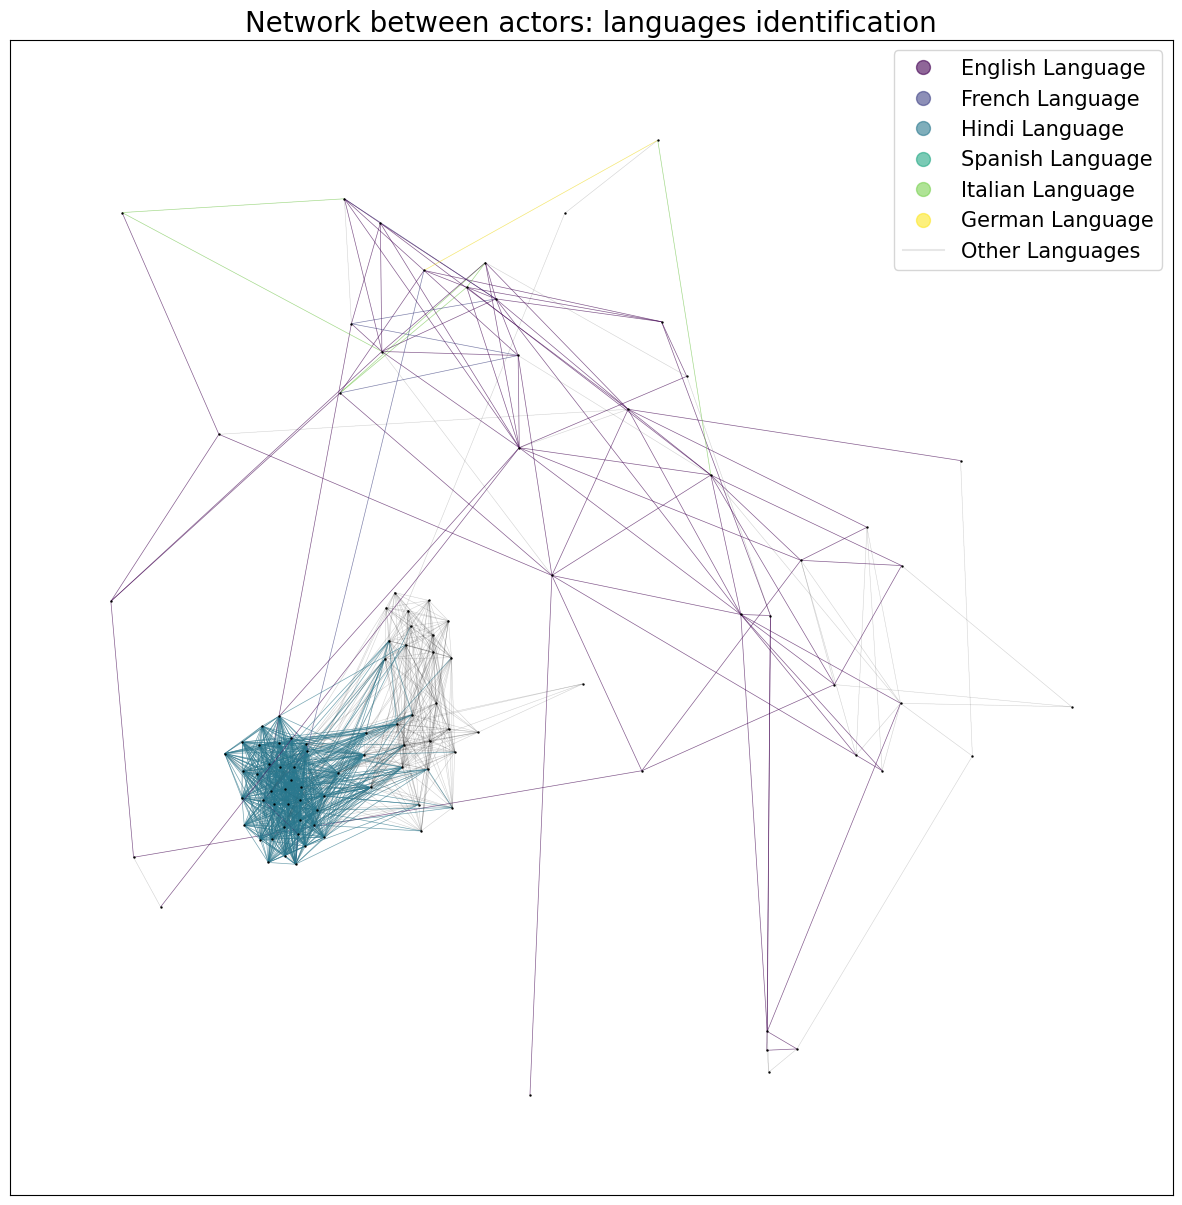

time to compute: 1.0 seconds


In [46]:
plot_network_with_language(G, save =True)

### 3.2 Most paired movie language in actors career

Do the actors playing in a language play in movie in other language ?

In [47]:
nb_language = 6
#create a dataset of actor that have played in "nb_language" most represeted languages. set 1 if appear in a language, 0 otherwise
actor_language = create_actor_language_dataset(Movie, Actor, nb_language)

In [48]:
# creat a dict per languages kept. each value are df only with actor that have played in this specific language
actor_count_per_language = create_cross_language(actor_language)

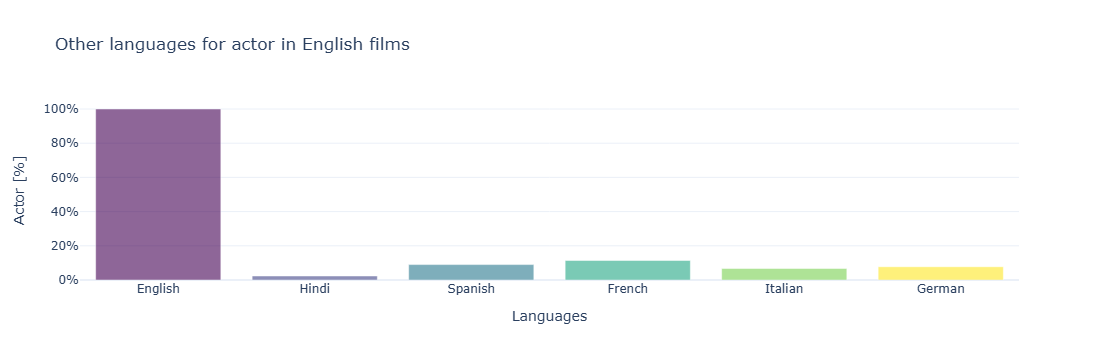

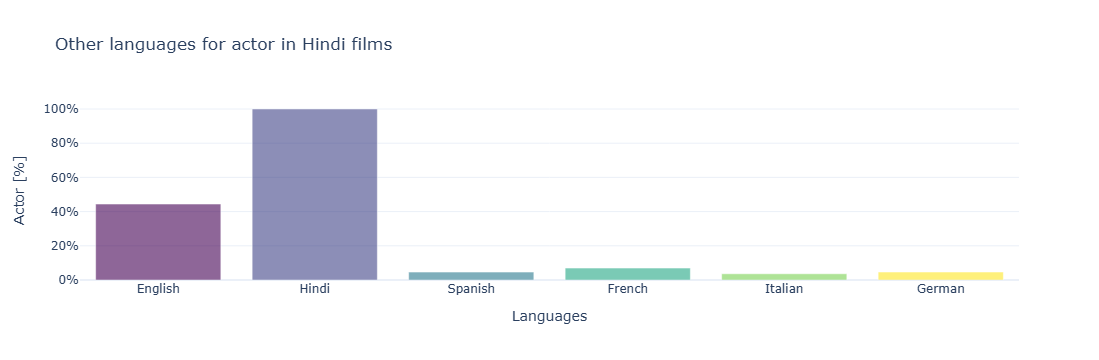

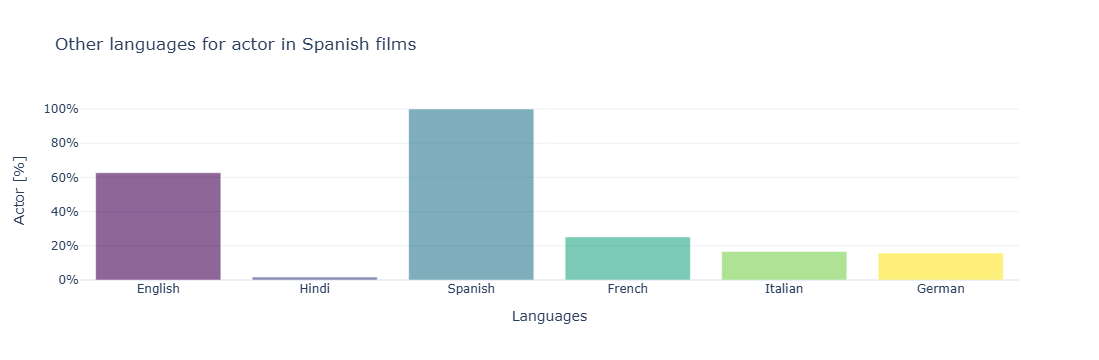

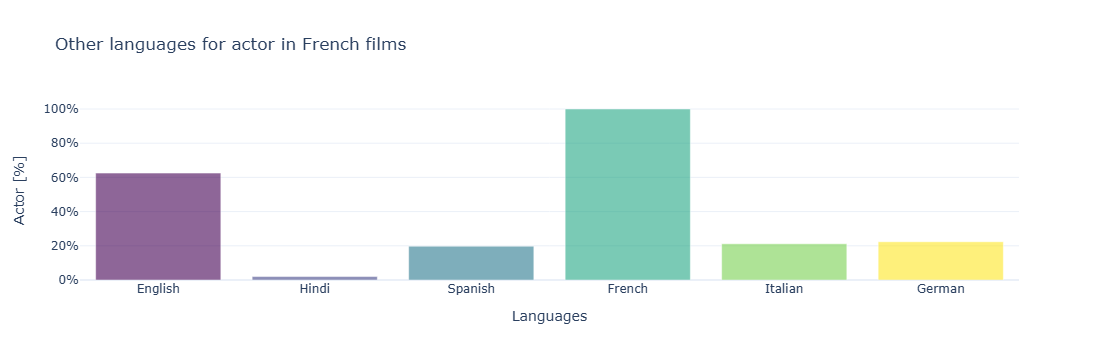

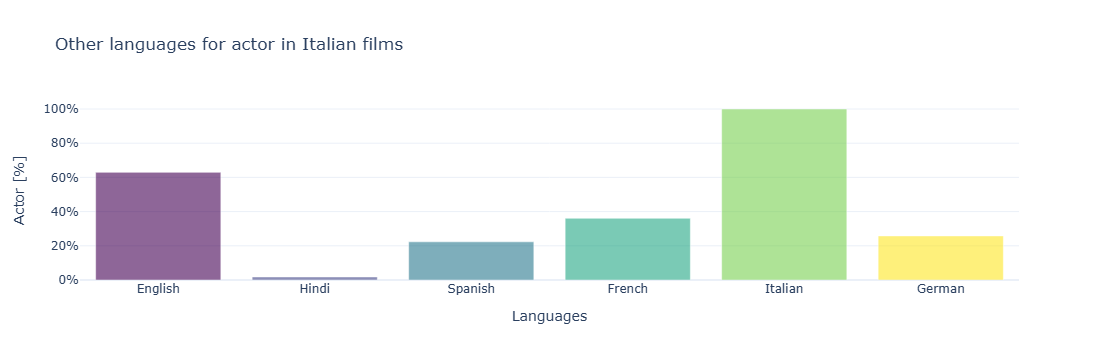

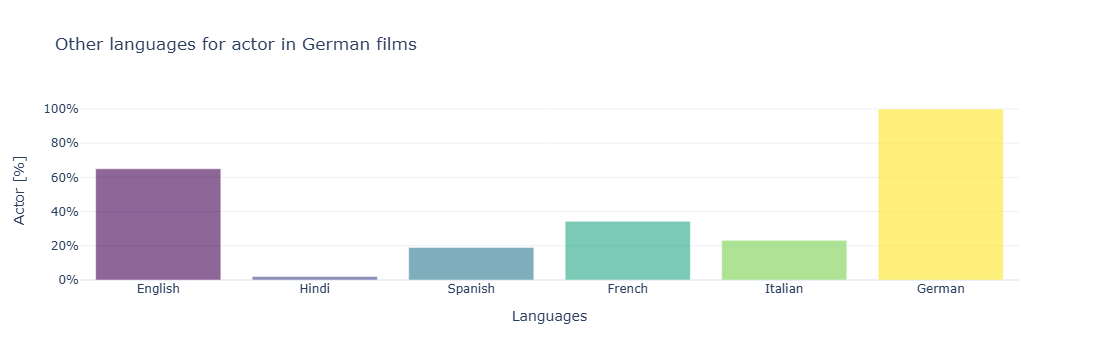

In [49]:
# plot previous dict (one for each languages kept)
plot_language_histograms(actor_count_per_language)

These graphs allow us to draw conclusions about typical language pairs in an actor's career. This means, for example, that 36% of actors who appeared in an Italian-language film also appeared in a French-language film. (5th graph) Or that only 2% of actors who appeared in an english-langage film also appeared in a Hindi-language film. (first graph)

**QUIZZ : Which actor has appeared in films of 9 out of the 10 most spoken movie languages?**

In [50]:
#create dataset with the 10 most spoken movie languages :
actor_language2 = create_actor_language_dataset(Movie, Actor, 10)

In [51]:
one_zero = (actor_language2 > 0).astype(int)
one_zero["sum"] = one_zero.sum(axis=1)
freebase_id = one_zero[one_zero["sum"]>8].index.to_list()
one_zero[one_zero["sum"]>8]

languages_played = one_zero[one_zero["sum"] > 8].iloc[:, :-1] 
languages_played_columns = languages_played.columns[languages_played.iloc[0] == 1]
print(f"The actor is Jacky Chan {freebase_id}, and has played in \n {languages_played_columns.to_list()}")

The actor is Jacky Chan ['/m/012d40'], and has played in 
 ['English Language', 'Hindi Language', 'Spanish Language', 'French Language', 'Italian Language', 'German Language', 'Japanese Language', 'Tamil Language', 'Malayalam Language']


### 3.3 Relationship between actor with productive career and movie languages :

In [52]:
# do the analysis for the 6 most representative languages
nb_language = 6
# take the cluster from part 1 (cluster 0 : short career, cluster 1 : top career, cluster 2 : mid career)
cluster0, cluster1, cluster2 = dict_cluster[0], dict_cluster[1], dict_cluster[2]

#create a dataset of actor that have played in "nb_language" most represeted languages.
actor_language0 = create_actor_language_dataset(Movie, cluster0, nb_language)
actor_language1 = create_actor_language_dataset(Movie, cluster1, nb_language)
actor_language2 = create_actor_language_dataset(Movie, cluster2, nb_language)

In [53]:
# We decide to merge mid career with top career for analysis
actor_language_concat_1_2 = pd.concat([actor_language1, actor_language2], axis=0)
actor_language_concat_1_2[actor_language_concat_1_2.iloc[:,0:] > 0] = 1
actor_language0[actor_language0.iloc[:,0:] > 0] = 1

#create dict containing the 2 datasets and set the number of group to 2
nb_group = 2 
dict_actor_language = {0: actor_language0, 1: actor_language_concat_1_2}

In [54]:
# create a dict that has a key per group and the movie count distribution for each language
distribution_dict = create_distribution_for_each_group(dict_actor_language, number_group = 2)

We are interested to see if the people with short career have the same language distribution as actor with mid or top career. <br> Let's do a Chi2 test !

**Null hypothesis** : the distribution between languages is independant of career profile.

In [55]:
# take correct shape of the distribution to be tested on a CHi2 test :
matrix = pd.DataFrame(distribution_dict, index=[1,2]).T
# do chi2 test (5%)
chi2, p_value, dof, expected = chi2_contingency(matrix)
#print result
print_result_chi2(chi2, p_value, dof, expected)

Chi-2 : 2774.527407570477
P-value : 0.0
degree of freedom : 5
Distribution are significantly statistically different (p < 0.05).


In [56]:
# get the "nb_language" most represented movie languages.
list_languages = get_most_represented_language(Movie, nb_language)

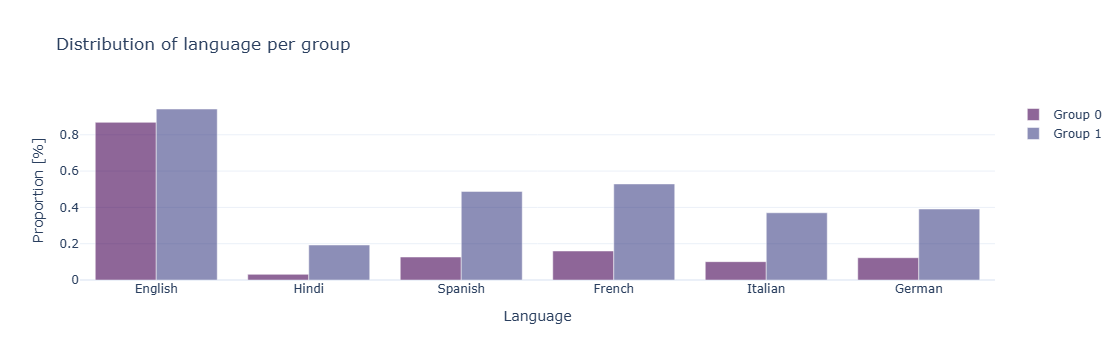

In [57]:
plot_group_distribution_language(matrix, nb_group, list_languages,dict_actor_language)